<a href="https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter?scriptVersionId=183177066" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# Automated Essay Scoring 2.0 with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

<div align="center">
    <img src="https://i.ibb.co/BrZf1MC/AESv2.jpg">
</div>

In this competition, our aim is to develop an AI model that can score student essays. This competition is actually an updated version of an old one that took place over a decade ago. In this version, we aim to improve upon essay scoring algorithms to enhance student learning outcomes. This notebook will guide you through the process of fine-tuning the **DebertaV3** model using **Ordinal Regression/Classification** to score student essays using KerasNLP.

**Did you know**: This notebook is backend-agnostic, which means it supports TensorFlow, PyTorch, and JAX backends. However, the best performance can be achieved with `JAX`. KerasNLP and Keras enable the choice of the preferred backend. Explore further details on [Keras](https://keras.io/keras_3/).

**Note**: For a deeper understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).

# 📚 | Import Libraries 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch" 

import keras_nlp
import keras
import keras.backend as K
import tensorflow as tf

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

2024-06-13 02:47:32.551151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 02:47:32.551249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 02:47:32.686266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_26/2827391943.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


## Library Version

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 3.0.5
KerasNLP: 0.8.2


# ⚙️ | Configuration

In [3]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 32  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
keras.utils.set_random_seed(CFG.seed)

# 🧮 | Mixed Precision

In [5]:
keras.mixed_precision.set_global_policy("mixed_float16")

# 📁 | Dataset Path 

In [6]:
BASE_PATH = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2'

# 📖 | Meta Data

**Files in the dataset:**

- `{test|train}.csv`
  - `essay_id`: Unique identifier for each essay.
  - `full_text`: Essay text.
  - `score`: Essay's score from `1-6`.
- `sample_submission.csv`: Valid sample submission.

**What does the `score` mean?**

The `score` represents the quality of student-written argumentative essays. Essays were rated based on a rubric covering perspective development, critical thinking, evidence use, organization, language, and grammar/mechanics. Here's a summary of the scoring criteria:

| Score | Description |
|-------|-------------|
| 6     | Clear mastery with few errors, outstanding critical thinking, appropriate evidence, well-organized, skilled language use. |
| 5     | Reasonable mastery with occasional errors, strong critical thinking, generally appropriate evidence, well-organized, good language use. |
| 4     | Adequate mastery with some lapses, competent critical thinking, adequate evidence, generally organized, fair language use. |
| 3     | Developing mastery with weaknesses, limited critical thinking, inconsistent evidence, limited organization, fair language use with weaknesses. |
| 2     | Little mastery with serious flaws, weak critical thinking, insufficient evidence, poor organization, limited language use with frequent errors. |
| 1     | Very little or no mastery, severely flawed, no viable point of view, disorganized, fundamental language flaws, pervasive grammar/mechanics errors. |

> This grading is very similar to the grading used in the [ETS GRE (Graduate Record Examinations) AWA](https://www.ets.org/gre/test-takers/general-test/prepare/content/analytical-writing.html) exam, where prospective graduate students are asked to write essays to judge their analytical abilities, and their scores are later used for graduate admission. 


In [7]:
# Load data
df = pd.read_csv(f'{BASE_PATH}/train.csv')  # Read CSV file into a DataFrame

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Train Data: 17,307
# Sample:


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [8]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["score"])

# 🧂 | Process Labels for Ordinal Regression

**What is Ordinal Regression?**
Ordinal regression is a type of supervised learning algorithm used to predict an ordinal or ranked dependent variable. Unlike in typical classification problems where the target variable is categorical, in ordinal regression the target variable has a ordering or ranking. It is also different from typical regression, where the target variable is continuous. In ordinal regression, the target variable has a discrete, ordered set of values, such as levels of satisfaction or performance grades.

**Why do we need it?**
Ordinal regression is useful when the target variable (in our competition, the `score` of an essay) represents a ranking or order. Specifically, ordinal regression can capture the inherent order in the target variable, which standard classification models may not be able to do effectively.

For Ordinal Regression, we have to transform the labels, which is different from typical classification or regression. The following code will convert essay scores to an ordinal matrix, which will be used as the ground truth for calculating the loss.

In [9]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [10]:
scores = [1, 3, 5, 2, 6]

to_ordinal(scores)

array([[1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.]], dtype=float32)

## Label Conversion

In [11]:
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

# 🎨 | EDA

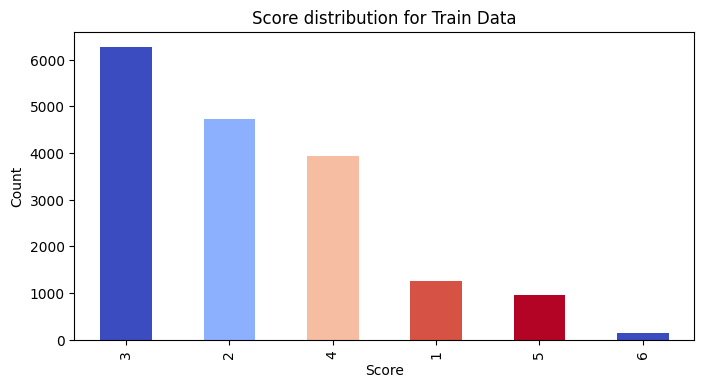

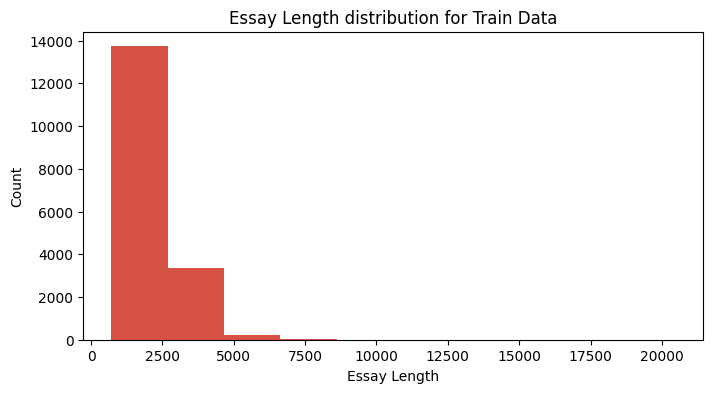

In [12]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
df['essay_length'] = df.full_text.map(len)
df.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [13]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [14]:
inp = preprocessor(df.full_text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (512,)
padding_mask : (512,)


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [15]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [16]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds

## Build Train/Valid Dataset

The function below generates the training and validation datasets.

In [17]:
# Train Data
train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)


# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [18]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

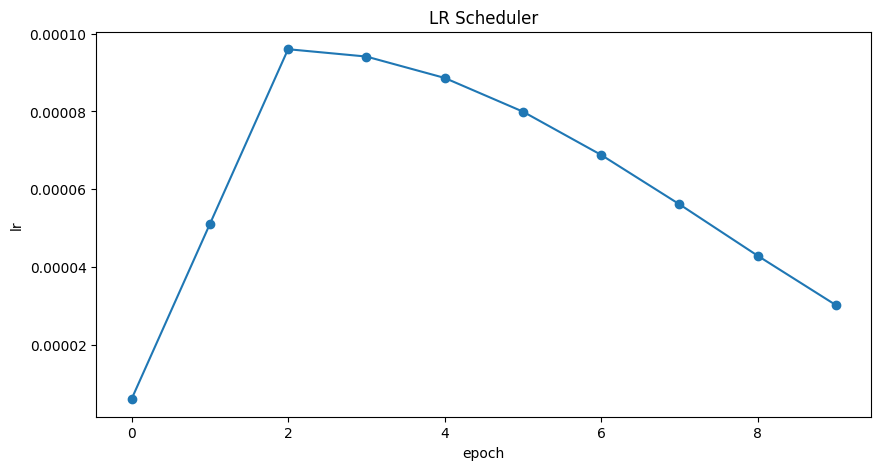

In [19]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# 💾 | Model Checkpointing

The following code will create a callback that will save the best checkpoint of the model during training, which we will use for inference in the submission.

In [20]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)


# 📏 | Metric

The metric for this competition is quadratic **Weighted Kappa**. This metric is particularly useful for tasks involving ordinal classification (where labels have inherent order). The following code implements this metric from scratch. This metric is implemented taking inspiration from [this TensorFlow implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/WeightedKappaLoss). You can learn more about this metric [here](https://www.sciencedirect.com/science/article/abs/pii/S0167865517301666). 

> This metric implementation is a bit different than the competition metric, which was resolved by @taichiuemura in [here](https://www.kaggle.com/code/taichiuemura/aes-2-0-kerasnlp-starter/#%F0%9F%93%8F-%7C-Metric).

In [21]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name="o_sum", initializer="zeros")
        self.e_sum = self.add_weight(name="e_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6
        )
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)


# 🤖 | Modeling



## KerasNLP Classifier

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including `Bert`, `Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of `DebertaV3`. However, feel free to explore all available models in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). Also, for a deeper understanding of `KerasNLP`, refer to the informative [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach involves using `keras_nlp.models.DebertaV3Classifier` to process each text and generate logits. These logits are passed through a `sigmoid` function to produce the final output.

> Note that we are tackling this problem as an **ordinal regression** problem, thus we have used `sigmoid` activation, but we can also consider this problem as a classification problem; then, we would've used `num_classes=6`, `softmax` activation, and `categorical_crossentropy` loss. We could even consider this as a **regression** problem with `num_classes=1`, `no activation` layer, and regression losses like MSE, MAE, etc. You are welcome to experiment with the typical classification and regression methods.

In [22]:
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)
model.summary()


Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 70,832,262 │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,832,262 (270.20 MB)

 Trainable params: 70,832,262 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

# 🚂 | Training

Following code will train the model on the training dataset and evaluate on the validation dataset.

In [23]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - loss: 0.4976 - weighted_kappa: 0.0938 - val_loss: 0.2148 - val_weighted_kappa: 0.6493 - learning_rate: 6.0000e-06
Epoch 2/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 430s 994ms/step - loss: 0.1972 - weighted_kappa: 0.6772 - val_loss: 0.1684 - val_weighted_kappa: 0.7519 - learning_rate: 5.1000e-05
Epoch 3/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 429s 993ms/step - loss: 0.1654 - weighted_kappa: 0.7427 - val_loss: 0.1645 - val_weighted_kappa: 0.7676 - learning_rate: 9.6000e-05


## Result Summary

In [24]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(model.history.history['val_weighted_kappa'])
best_score = model.history.history['val_weighted_kappa'][best_epoch]
best_loss = model.history.history['val_loss'][best_epoch]

# Print and display best results
print(f'\n{"=" * 17} RESULTS {"=" * 17}')
print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Score : {best_score:.3f}\n>>>> BEST Epoch : {best_epoch}')
print('=' * 50)


================= RESULTS =================
>>>> BEST Loss  : 0.165
>>>> BEST Score : 0.768
>>>> BEST Epoch : 2


# 🧪 | Testing

In this section, we will visually test how our model performs on some samples from the validation data.

> Note that we are converting the ordinal regression model outputs with `sum`, unlike a typical classification problem where we would use `argmax`.

In [25]:
# Load best checkpoint
model.load_weights("best_model.weights.h5")

# Make predictions using the trained model on last validation data
valid_preds = model.predict(valid_ds, verbose=0)

# Format predictions and true answers
pred_scores = np.sum((valid_preds > 0.5).astype(int), axis=-1)
true_scores = valid_df.score.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.full_text
    pred_answer = pred_scores[i]
    true_answer = true_scores[i]
    print(f"❓ Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


# Predictions

❓ Text 1:
Venus, Future planet earth?

Should we take more risks and stop being limited by danger and doubts? I think that the author give such good information ....  about Venus and also about why it's a good idea to start studying this planet. We have to start meeting the very edges of imagination and innovation.

✅ True: 3

🤖 Predicted: 2

------------------------------------------------------------------------------------------ 

❓ Text 2:
Joining this prgram was the best. There was a few incidents that happened while I was on this trip, but it was an amazing experience.

When I was on t .... n the ocean instead of being afraid to go because of sea sick and stuff. Itll be alot of fun if people go. They will enjoy thereselves and be alright.

✅ True: 3

🤖 Predicted: 3

------------------------------------------------------------------------------------------ 

❓ Text 3:
Have you ever wonder if you car was safe? What if you were causing enviornmental damage? Would you 

# 📬 | Submission

In this section, we will infer our model on the test data and then finally prepare the submission file.

## Build Test Dataset

In [26]:
# # Train Data
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")
test_texts = test_df.full_text.fillna("").tolist()  # Extract training texts

# Build training dataset
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(CFG.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  # include all samples
)


## Inference on Test Data

In [27]:
# Do inference
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


## Create Submission File

In [28]:
# Create a DataFrame to store the submission
sub_df = test_df[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = test_preds

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()

,essay_id,score
0,000d118,2
1,000fe60,2
2,001ab80,4


# ✍️ | Reference
* [LLM Science Exam: KerasCore + KerasNLP [TPU]](https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu)
* [Keras NLP](https://keras.io/api/keras_nlp/)
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte